Lecture week 2
==============



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from scipy import optimize
import statsmodels.api as sm # check the error that cannot import name 'factorial' in from scipy.misc import factorial
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras


## Overview: distributions, bootstrapping, OLS, causality



### distributions



-   important idea when you want to estimate a model/neural network:
    -   generate your own data and then estimate the model on these data
    -   last week we looked at the distribution of a slope
    -   here we consider the distribution of the mean of a sample



In [2]:
sample_size = 10
simulated_data = np.mean(tf.random.uniform([10000,sample_size],0,1),axis=1)
simulated_data.shape

(10000,)

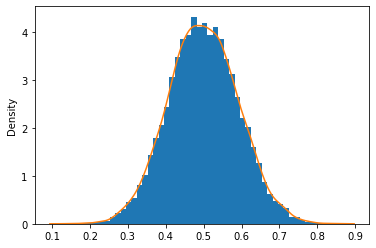

In [3]:
plt.hist(simulated_data,bins=50,density=True)
sns.kdeplot(simulated_data);

This shows us that statistics like a mean have a distribution. We can compare this distribution to the values that we put into the data ourselves: in the example above, we draw from a population with a uniform distribution on $[0,1]$. Hence, the population mean equals 0.5.

The histogram shows that on average the sample mean is close to 0.5, but with a sample of 10 there is quite some variation. You can draw a sample where the mean equals 0.3.



### bootstrapping



-   Bootstrapping takes this idea one step further:
    -   when using &ldquo;fake&rdquo; data (which we generate ourselves), we can test properties directly on the sample by generating 1000 such samples
        -   and then we do not need to worry whether the statistic has a $t$ or $F$ distribution
    -   with bootstrapping we have **one** sample with real data
    -   to get a distribution for our statistic (say, slope), we randomly draw a sample from our sample **with replacement**
    -   on each of these samples (from our sample), we calculate our statistic
    -   this gives us the distribution of our statistic

We draw our data this time from a multivariate normal distribution with a covariance not equal to 0:



[1.58544167 0.54818665]


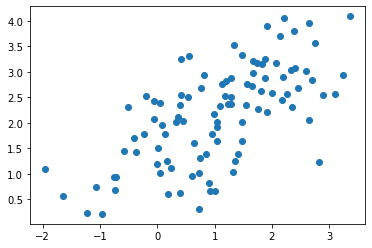

In [4]:
mean = [1, 2]
cov = [[1, 0.6], [0.6, 1]]
n = 100

x = np.random.multivariate_normal(mean, cov, (n))
print(sm.OLS(x[:,1],sm.add_constant(x[:,0])).fit().params)
plt.scatter(x[:,0],x[:,1]);

Let&rsquo;s suppose that this is our &ldquo;real&rdquo; data. That is, we cannot generate more data from the data generating process; this is the data that we have.

How can we generate a distribution for our slope? We draw samples from our sample using `np.random.choice()`:



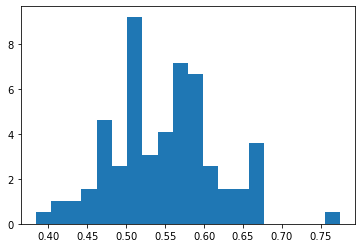

In [5]:
slopes = []
for i in np.arange(100):
    sample = np.random.choice(n,size = n, replace=True)
    slopes.append(sm.OLS(x[:,1][sample],sm.add_constant(x[:,0][sample])).fit().params[1])

plt.hist(slopes,bins=20,density=True);

To illustrate how `random.choice()` works:

In [19]:
np.random.choice(["one","two","three"], 8, replace=True)

array(['two', 'two', 'two', 'one', 'two', 'one', 'one', 'three'],
      dtype='<U5')

In [22]:
np.random.choice(8,10,replace=True)

array([4, 2, 2, 6, 3, 5, 1, 2, 4, 3])

We can use a list of indices to select items from a numpy array. The syntax is: `np.array([1,2,3,4])[list with indices]` Because the list with indices is also a list, we get two sets of brackets: `[[0,2,2,-2]]`

In [27]:
np.array([1,2,3,4])[[0,2,2,-2]]

array([1, 3, 3, 3])

-   one of the fun things of bootstrapping is to think about your data
-   how do we test the null-hypothesis that there is no relation between x and y?
-   that is, how should we sample from our sample to test the null hypothesis of slope equal to zero?



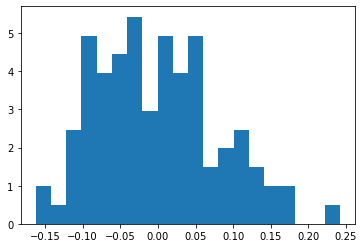

In [6]:
slopes = []
for i in np.arange(100):
    sample_x = np.random.choice(n,size = n, replace=True)
    sample_y = np.random.choice(n,size = n, replace=True)
    slopes.append(sm.OLS(x[:,1][sample_y],sm.add_constant(x[:,0][sample_x])).fit().params[1])

plt.hist(slopes,bins=20,density=True);

### your own OLS



-   OLS is basically a minimization problem (sum of squared residuals)
-   when adding more parameters, the fit can only get better (lower sum of squared residuals)
-   but by adding more variables, we run the risk of overfitting: we pick up aspects of the sample that do not generalize to the population
-   one way to avoid overfitting is to add a penalty term to the minimization problem for each variable added to the OLS regression:
    -   ridge and lasso regressions

Many people choose the variables for their OLS estimation based on significance. They add variables that turn out to be significant and drop variables that are not significant.

This is wrong!

Significance is different from model selection. Model selection is based on theory; not stars in a table.

-   5% significance:
    -   in an OLS regression: even if a variable $x_i$ has no effect on $y$, there is a 5% probability that you find a significant effect
    -   if you have 20 irrelevant variables, on average one of these will be significant
    -   with &ldquo;big data&rdquo; you will have more than 20 explanatory variables
    -   hence you need to be careful in what you put into your regressions
-   some people have a &ldquo;better safe than sorry&rdquo; attitude: add as many variables as possible to control for &ldquo;things&rdquo;
-   this has two problems:
    -   some of these variables will be significant (if you have more than 20 of them)
    -   messes up your causal interpretation of your regression results (see below)

Consider the following example where we select variables based on whether they are significant at the 5% level.



In [7]:
nobs = 100
X = np.random.normal(0,1,size=(nobs, 20))
X = sm.add_constant(X)
beta = np.zeros(21)
e = np.random.normal(0,1,size=nobs)
y = np.dot(X, beta) + e

results = sm.OLS(y, X).fit()
np.sum(results.pvalues<0.05)
# print(results.summary())

0

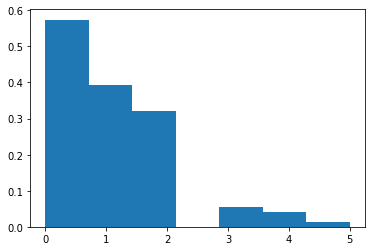

In [8]:
signif_variables = []
for i in range(100):
    X = np.random.normal(0,1,size=(nobs, 20))
    X = sm.add_constant(X)
    beta = np.zeros(21)
    e = np.random.normal(0,1,size=nobs)
    y = np.dot(X, beta) + e

    results = sm.OLS(y, X).fit()
    signif_variables.append(np.sum(results.pvalues<0.05))

plt.hist(signif_variables,bins = 7,density=True);

![img](https://imgs.xkcd.com/comics/significant.png)

An automated way to select variables is based on their predictive power. We add a penalty to the OLS minimization problem for having an additional parameter (not equal to zero).

For lasso and ridge regressions to make sense, you need to standardize the variables!

To keep things simple, we will generate variables that are already standardized.

We define the loss function:



In [42]:
def loss_lasso(w,λ,X,y):
    loss = np.sum((np.dot(X,w)-y)**2)/len(y) + λ * np.sum(np.abs(w))
    return loss

Then we go through the same 100 iterations as above and check how often an unrelated variable is added to the regression:



In [43]:
n_variables = 20
penalty = 0.7
lasso_weights = []
for i in range(100):
    X = np.random.random((nobs, n_variables))
    y = np.random.random(nobs)
    res = optimize.minimize(lambda w: loss_lasso(w,penalty,X,y),np.zeros(n_variables))
    lasso_weights.append(np.sum(np.abs(res.x)))

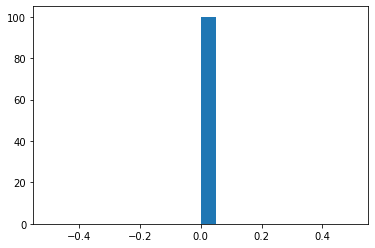

In [44]:
plt.hist(lasso_weights,bins=20);

With high enough penalty $\lambda$, we find that all coefficients are indeed zero.

But if you set the penalty too high, even variables that do affect $y$ will be dropped from the regression.

The penalty affects the outcome of the regression, but is itself not estimated: hyperparameter

Hyperparameters need to be &ldquo;tuned&rdquo;



### causality



-   OLS gives you correlations
    -   there is nothing wrong with that!
    -   but we tend to interpret these correlations as causal effects
    -   here we can make three mistakes:
        -   the fork
        -   the pipe
        -   the collider
    -   use economic theory to understand in which situation you are

To understand the mistakes you can make when moving from correlation to causality, we simulate our own data. Hence, we know what the underlying causal effects are. Then we use OLS to see what coefficients we find and how we can interpret these.

-   three mistakes you can make when interpreting an OLS regression as a causal model:
    -   fork: x and y are unrelated but both are correlated with a variable z that is not in the regression
        -   you get the impression that x is causing y
        -   the correct statement is: x and y are correlated
        -   you solve the causality misinterpretation by adding z as explanatory variable
        -   this is the reason for the &ldquo;better safe than sorry&rdquo; attitude
    -   pipe: there is a causal effect from x on y and it is mediated by z
        -   running an OLS regression with x and z as explanatory variables suggests that there is no causal effect of x on y
        -   the &ldquo;correct&rdquo; regression here is to include only x as explanatory variable
        -   (economic) theory helps you to distinguish the fork from the pipe
    -   collider: if you cannot control for all relevant variables, controlling for some of them can give &ldquo;unexpected results&rdquo;
        -   example of notebook: find effect of grandparent education on grandchild education, controlling for parental educational achievement
        -   leads to negative correlation between grandparent and grandchild education
        -   because parental education contains information about a variable (neigborhood) that affects both grandparent and grandchild education

Here we model the fork as an illustration:



In [45]:
n = 100
z = np.random.normal(0,1,size = n)
x = 2 * z + np.random.normal(0,1,size=n)
y = -1 * z + np.random.normal(0,1,size=n)
data = pd.DataFrame({'x':x,'y':y,'z':z})
data.head()

,x,y,z
0,1.244817,-1.767749,0.443857
1,-1.900986,1.032423,-0.159776
2,-3.509210,-0.605795,-0.483883
3,1.769457,0.355486,1.285375
4,4.461674,-0.298696,1.742108


The following regression seems to suggest that x causes y:



In [46]:
smf.ols('y ~ x', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     39.46
Date:                Tue, 08 Feb 2022   Prob (F-statistic):           9.24e-09
Time:                        16:50:03   Log-Likelihood:                -152.40
No. Observations:                 100   AIC:                             308.8
Df Residuals:                      98   BIC:                             314.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0170      0.112      0.151      0.880      -0.206       0.240
x             -0.2981      0.047     -6.282      0.000      -0.392      -0.204
==============================================================================
Omnibus:                        1.482   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.477   Jarque-Bera (JB):                1.248
Skew:                           0.274   Prob(JB):                        0.536
Kurtosis:                       3.005   Cond. No.                         2.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

But this effect disappears once we control for z:



In [47]:
smf.ols('y ~ x + z', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     32.94
Date:                Tue, 08 Feb 2022   Prob (F-statistic):           1.21e-11
Time:                        16:51:20   Log-Likelihood:                -143.40
No. Observations:                 100   AIC:                             292.8
Df Residuals:                      97   BIC:                             300.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0776      0.104      0.746      0.457      -0.129       0.284
x              0.1027      0.101      1.012      0.314      -0.099       0.304
z             -1.0586      0.242     -4.373      0.000      -1.539      -0.578
==============================================================================
Omnibus:                        1.692   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.162
Skew:                           0.111   Prob(JB):                        0.559
Kurtosis:                       3.479   Cond. No.                         6.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Next week: tensors, first neural network, over/under fitting



-   tensors are vectors/matrices that capture multidimensional data
-   we tend to think in two dimensional tables (&ldquo;excel&rdquo;) but some phenomena have higher dimensions than 2
-   a set of images, say we want to separate images of cats and dogs
-   one observation has two dimensions (x and y axis), say I have 50\*50 &ldquo;pixels&rdquo;
-   if I have 3000 observations, my data has dimensions 3000\*50\*50
-   you cannot do this in excel&#x2026;
-   to deal with such data in python, we need tensors
-   we introduce tensors in `numpy` and explain how you can work with them (e.g. add them together, multiply them)
-   this is different than with matrices:
    -   I can multiply an $n*m$ and $k*l$ matrix if and only if $m=k$
    -   this is not true for multiplying tensors
-   an important concept with tensors is: broadcasting
-   with tensors you will use (the attribute) `.shape` a lot
-   you will learn how to select observations from a tensor using slicing and indexing



In [51]:
A = np.arange(24).reshape(2,3,4)
A.shape

(2, 3, 4)

In [49]:
A

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [54]:
print(A[0,:,:])
print('\n')
print(A[1,:,:])

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


[[12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]]


In [57]:
A[1,2,:]

array([20, 21, 22, 23])

Recall matrix multiplication: we multiply a (2,3) matrix and (3,1) vector and the result is a (2,1) vector:



In [58]:
B = np.random.normal(0,1,size=(2,3))
C = np.random.normal(0,1,size=(3,1))
B.dot(C)

array([[ 0.49454338],
       [-2.27593168]])

But multiplying **tensors** B and C gives an error:



In [59]:
B*C

ValueError: operands could not be broadcast together with shapes (2,3) (3,1) 

When multiplying tensors, the dimensions need to be same or satisfy the broadcasting rules:



In [60]:
print(A * B[:,:,np.newaxis])
print('\n')
print((B[:,:,np.newaxis]).shape)

[[[  0.           1.23338322   2.46676644   3.70014966]
  [ -3.96179061  -4.95223826  -5.94268592  -6.93313357]
  [  0.18407785   0.20708758   0.23009731   0.25310704]]

 [[-14.27061946 -15.45983775 -16.64905603 -17.83827432]
  [  1.02479762   1.08884748   1.15289733   1.21694718]
  [-38.54341516 -40.47058591 -42.39775667 -44.32492743]]]


(2, 3, 1)


Slicing and indexing:



In [64]:
A[:,:2,:2]

array([[[ 0,  1],
        [ 4,  5]],

       [[12, 13],
        [16, 17]]])

# selecting entries with booleans:



In [65]:
A[A>5]

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23])

-   we introduce our very first neural network
-   and the functions &ldquo;relu&rdquo; and &ldquo;softmax&rdquo;

Tensor in our data and the correct label:



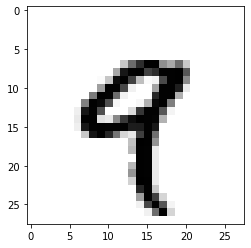

9


In [66]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
plt.imshow(train_images[4],cmap=plt.cm.binary)
plt.show()
print(train_labels[4])

In [67]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
model.fit(train_images, train_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 7.1405 - accuracy: 0.8221
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4382 - accuracy: 0.9006
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3043 - accuracy: 0.9251
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2346 - accuracy: 0.9383
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.2644 - accuracy: 0.9416

Test accuracy: 0.9416000247001648


-   overfitting: you pick up structure that is particular to the sample but does not generalize to the population
-   underfitting: the sample contains relevant information about the population but your model is too simple to pick this up
    
    To see how this work, we simulate our own data:
    
    -   we know which structure is relevant for the population (we programmed it)
    -   then we create models that over/underfit the sample and see what the properties are of such models
    -   find ways to steer between underfitting and overfitting:
        -   in the sample, adding more variables always improves the fit
        -   but this is not necessarily the case out-of-sample
        -   hence we split our data into a train set and a test set
        -   make model decisions based on performance in the test set (not the train set)

